In [2]:
import json
import matplotlib.pyplot as plt
import re
from github import Github, Auth
import requests
from urllib.parse import urlparse

# Taking the right references

Some of the references refers to different repositories, so here it's fixed. It takes the repository that is mentioned in the website (see app_selection.ipynb)

## Load files

In [ ]:
# Load data from file A
with open('phpCVEs.json', 'r') as file:
    data_cve = json.load(file)

# Load data from file B
with open('phpAppsWithGithubLinks.json', 'r') as file:
    data_gh_links = json.load(file)

## The core process

In [23]:
combined_data = []
for entry_gh in data_gh_links:
    appname_gh = entry_gh['appname']
    github_href_gh = entry_gh['github_href']

    # Find entries in data_cve with the same appname
    relevant_entries_cve = [entry_cve for entry_cve in data_cve if entry_cve['app'] == appname_gh]
    
    for entry_cve in relevant_entries_cve:
        references_cve = entry_cve.get('references', [])
        # Iterate through references in data_cve
        final_refs = []
        for reference_cve in references_cve:
            
            match = re.match(r'https://github.com/([^/]+)/([^/]+)/?', reference_cve)
            if match:
                github_user_cve = match.group(1)
                github_repo_cve = match.group(2)
                
                # Check if GitHub username and repository match those in data_gh_links
                if github_user_cve == github_href_gh.split('/')[-2] and github_repo_cve == github_href_gh.split('/')[-1]:
                    # append the matched reference to final_refs
                    final_refs.append(reference_cve)
        
        # Construct combined entry
        combined_entry = {
            "appname": appname_gh,
            "cve_id": entry_cve["cve_id"],
            "references_transformed": final_refs,
            "original_references": entry_cve["references"],
            "gh_link": github_href_gh,
            "original_vuln": entry_cve["original_vuln"]
        }
        # Append combined entry to the list
        combined_data.append(combined_entry)
        
print("Combined Data:")
for entry in combined_data:
    entry_without_original_vuln = {key: value for key, value in entry.items() if key != "original_vuln"}
    print(json.dumps(entry_without_original_vuln, indent=4))

Combined Data:
{
    "appname": "NextCloud",
    "cve_id": "CVE-2016-9459",
    "references_transformed": [
        "https://github.com/nextcloud/server/commit/94975af6db1551c2d23136c2ea22866a5b416070"
    ],
    "original_references": [
        "https://github.com/nextcloud/server/commit/94975af6db1551c2d23136c2ea22866a5b416070",
        "https://github.com/owncloud/core/commit/044ee072a647636b1a17c89265c7233b35371335",
        "https://github.com/owncloud/core/commit/b7fa2c5dc945b40bc6ed0a9a0e47c282ebf043e1",
        "https://github.com/owncloud/core/commit/efa35d621dc7ff975468e636a5d1c153511296dc"
    ],
    "gh_link": "https://github.com/nextcloud/server"
}
{
    "appname": "NextCloud",
    "cve_id": "CVE-2016-9460",
    "references_transformed": [
        "https://github.com/nextcloud/server/commit/2da43e3751576bbc838f238a09955c4dcdebee8e",
        "https://github.com/nextcloud/server/commit/8aa0832bd449c44ec300da4189bd8ed4e036140c",
        "https://github.com/nextcloud/server/co

## Some visualizations to check

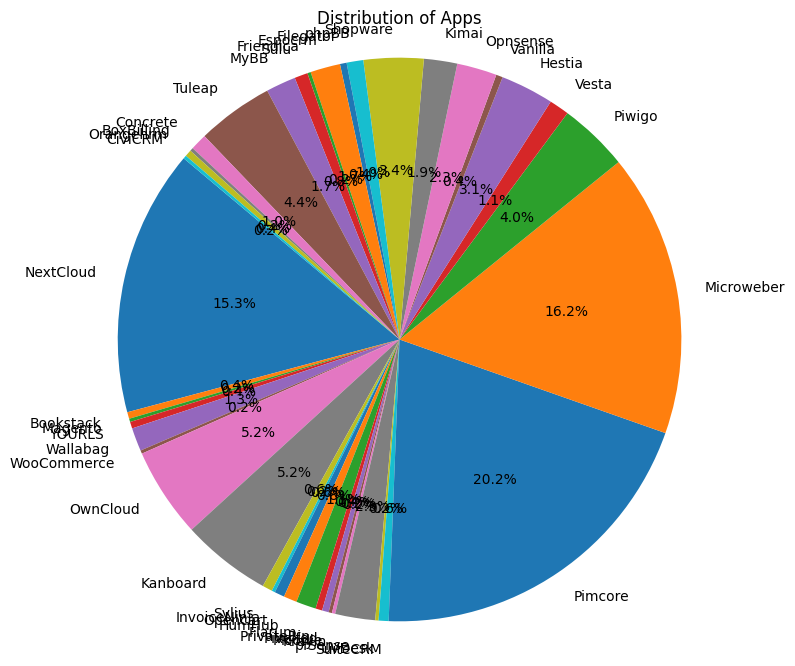

In [24]:
# Generate a pie chart of different apps
app_count = {}
for entry in combined_data:
    appname = entry['appname']
    app_count[appname] = app_count.get(appname, 0) + 1

labels = app_count.keys()
sizes = app_count.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Apps')
plt.axis('equal')
plt.show()

Number of entries in combined data: 524
Number of entries in original data: 524


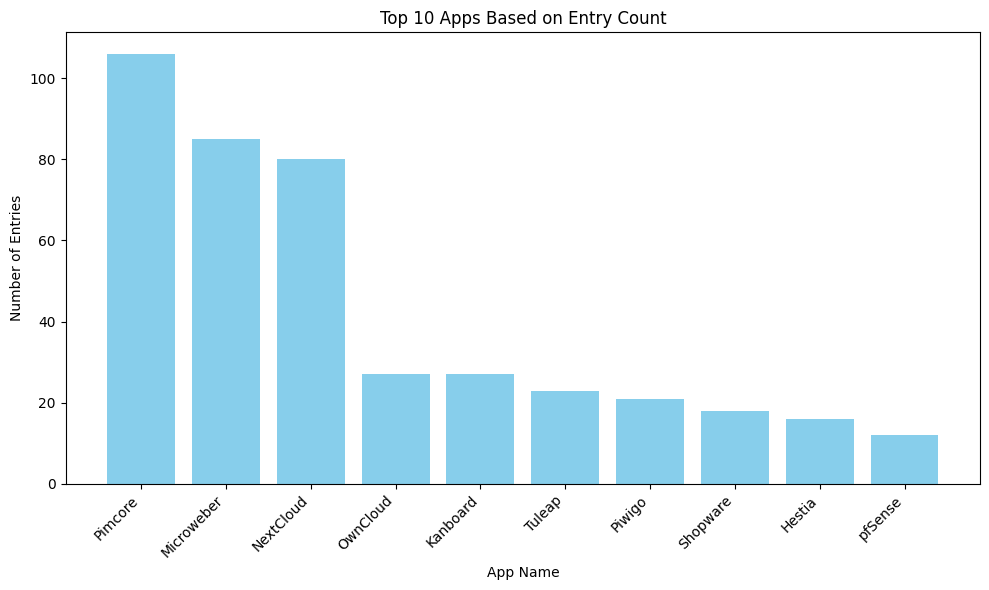

In [26]:


# Print the number of entries in combined_data
print(f"Number of entries in combined data: {len(combined_data)}")
print(f"Number of entries in original data: {len(data_cve)}")
# Count occurrences of each app in combined_data
app_counts = {}
for entry in combined_data:
    appname = entry['appname']
    app_counts[appname] = app_counts.get(appname, 0) + 1

# Sort the app counts and get the top 10 apps
top_10_apps = sorted(app_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract app names and counts for plotting
top_10_app_names = [app[0] for app in top_10_apps]
top_10_app_counts = [app[1] for app in top_10_apps]

# Create a bar graph of the top 10 apps
plt.figure(figsize=(10, 6))
plt.bar(top_10_app_names, top_10_app_counts, color='skyblue')
plt.xlabel('App Name')
plt.ylabel('Number of Entries')
plt.title('Top 10 Apps Based on Entry Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Saving the file

In [27]:
output_file = 'transformed_cve.json'
with open(output_file, 'w') as f:
    json.dump(combined_data, f, indent=4)

print(f"Combined data saved to {output_file}")

Combined data saved to transformed_cve.json


# Grouping by appname, taking non commit refs out, and PR to commits

## Grouping and adding pull request related attribute

In [2]:
with open('transformed_cve.json', 'r') as file:
    data = json.load(file)

In [3]:
def add_pullreq_attribute(data):
    for entry in data:
        pull_requests = []
        for reference in entry["references_transformed"]:
            match_pull_request = re.match(r"https://github.com/([^/]+)/([^/]+)/pull/(\d+)$", reference)
            if match_pull_request:
                pull_requests.append(reference)
        entry["pull_requests"] = pull_requests

In [4]:
add_pullreq_attribute(data)

In [9]:
def print_pretty_json(data):
    for entry in data:
        entry_without_original_vuln = {key: value for key, value in entry.items() if key != "original_vuln"}
        print(json.dumps(entry_without_original_vuln, indent=4))

For some reason the github api limit rate is annoying, so gota make things more efficient. First we group the data based on appname, also adds an attribute "has_pr".

In [16]:
def group_and_check_pr(data):
    grouped_data = {}
    for item in data:
        appname = item.get("appname")
        pull_requests = item.get("pull_requests")
        if appname not in grouped_data:
            grouped_data[appname] = {"data": [], "has_pull_request": False}
        grouped_data[appname]["data"].append(item)
        if pull_requests:  # Check if pull_request is not empty
            grouped_data[appname]["has_pull_request"] = True
    return grouped_data


In [17]:
grouped_data = group_and_check_pr(data)

In [18]:
with open('cve_transformation_process/grouped_cves.json', 'w') as file:
    json.dump(grouped_data, file, indent=4)

Check the number to verify if its all gucci

In [12]:
def calculate_totals(grouped_data):
    total_applications = len(grouped_data)
    total_entries = sum(len(group['data']) for group in grouped_data.values())
    return total_applications, total_entries

In [13]:
total_applications, total_entries = calculate_totals(grouped_data)

print("Total applications:", total_applications)
print("Total entries:", total_entries)

Total applications: 40
Total entries: 524


## References need to be further filtered
Now we need to do some further data transformation, references_transformed need to check some shits:
- if it's a commit, then we take it
- if it's a commits/master, we dont take it. The re is github root then commits right away
- if it's a pull req, dont take it (the pull req is already in another attribute)
- if it's a pull/{nr}/commit/.. we also take => this is transformed into gh_link/commit/{commit_nr}
- anything else, don't take it

In [51]:
with open('cve_transformation_process/grouped_cves.json', 'r') as file:
    grouped_data = json.load(file)

Here are the functions

In [52]:
def extract_new_reference(reference, entry):
    parts = reference.split("/")
    if "/pull/" in reference and len(parts) >= 5:
        # Extract pull and commit numbers from the pull request URL
        pull_index = parts.index("pull")
        
        if len(parts) > pull_index + 3 and parts[pull_index + 1].isdigit():
            
            pull_number = parts[pull_index + 1]
            commit_number_index = parts.index("commits") if "commits" in parts else None
            commit_number = parts[commit_number_index + 1] if commit_number_index is not None and len(parts) > commit_number_index + 1 else None
            # Construct the new reference URL
            if commit_number:
                new_reference = f"{entry['gh_link']}/commit/{commit_number}"
                return new_reference
    return None

def transform_references(grouped_data):
    for appname, app_data in grouped_data.items():
        for entry in app_data["data"]:
            references_transformed = []
            for reference in entry.get("references_transformed", []):
                new_reference = extract_new_reference(reference, entry)
                if new_reference:
                    references_transformed.append(new_reference)
                elif "/commit/" in reference:
                    references_transformed.append(reference)
            entry["references_transformed"] = references_transformed
    return grouped_data


Check if the functions is actually working

In [53]:
sample_data = {
    "grouped_data": {
        "app1": {
            "data": [
                {
                    "appname": "app1",
                    "references_transformed": [
                        "https://github.com/app1/repo/commit/123",
                        "https://github.com/app1/repo/pull/456/commits/789"
                    ],
                    "gh_link": "https://github.com/app1/repo"
                }
            ]
        },
        "app2": {
            "data": [
                {
                    "appname": "app2",
                    "references_transformed": [
                        "https://github.com/app2/repo/pull/987",
                        "https://github.com/app2/repo/commit/654",
                        "https://github.com/app2/repo/commits/master"
                    ],
                    "gh_link": "https://github.com/app2/repo"
                }
            ]
        }
    }
}

sample_entry = sample_data["grouped_data"]["app1"]["data"][0]
ref = sample_entry["references_transformed"][1]
new_ref = extract_new_reference(ref, sample_entry)
sample_transform = transform_references(sample_data["grouped_data"])
print(sample_transform)

{'app1': {'data': [{'appname': 'app1', 'references_transformed': ['https://github.com/app1/repo/commit/123', 'https://github.com/app1/repo/commit/789'], 'gh_link': 'https://github.com/app1/repo'}]}, 'app2': {'data': [{'appname': 'app2', 'references_transformed': ['https://github.com/app2/repo/commit/654'], 'gh_link': 'https://github.com/app2/repo'}]}}


Apply function to the actual data

In [54]:
transformed_grouped_data = transform_references(grouped_data)

Save the data

In [55]:
with open('cve_transformation_process/transformed_grouped_cves.json', 'w') as file:
    json.dump(transformed_grouped_data, file, indent=4)

## Trying PR to commits

A note: some commits in the PR is a merge commit, papers say don't take these commits as they don't really contribute anything. So to take them out, if a commit more than one parent commit, then it is a merge commit.

In [3]:
with open('cve_transformation_process/transformed_grouped_cves.json', 'r') as file:
    transformed_grouped_data = json.load(file)

This is the function that does it

In [22]:
def get_commits_and_check_merge(pull_url, token):
     # Parse the pull request URL to extract repository owner, name, and pull number
    parsed_url = urlparse(pull_url)
    path_parts = parsed_url.path.split('/')
    owner = path_parts[1]
    repo = path_parts[2]
    pull_number = path_parts[4]

    # Construct the GitHub API URL for the pull request
    api_url = f"https://api.github.com/repos/{owner}/{repo}/pulls/{pull_number}/commits"
    headers = {'Authorization': f'token {token}'}
    response = requests.get(api_url, headers=headers)
    commits = []
    if response.status_code == 200:
        commits_data = response.json()
        for commit in commits_data:
            if len(commit["parents"]) > 1: #This is to check if it's a merge commit
                print("merge commit found")
                print(commit["sha"])
            else:
                commits.append(commit["html_url"])
        if commits:
            return commits
        else:
            return None
    else:
        print("Failed to fetch commits:", response.text)
        return None

Let's test it

In [24]:
pull_link_test = "https://github.com/nextcloud/server/pull/21037"
token = ""#please put your own personal token
commits_result_test = get_commits_and_check_merge(pull_link_test, token)
print(commits_result_test)

['https://github.com/nextcloud/server/commit/7ad0f66fc437a63d9b4deac3cd74814882acd6f0', 'https://github.com/nextcloud/server/commit/c864e5dfc245e1de1bed6b73e11e5b3a4cdf65b7', 'https://github.com/nextcloud/server/commit/d1bd3ba594e2ee949a29a0ce53aaa6ba78aaf354', 'https://github.com/nextcloud/server/commit/0b0cc48c8830b71e9ed237c1866163bb85c5d379']


Let's apply it to the whole dataset

In [25]:
for appname, cve_data in transformed_grouped_data.items():
    for cve_entry in cve_data['data']:
        for pull_request in cve_entry.get('pull_requests', []):
            commits = get_commits_and_check_merge(pull_request, token)
            if commits:
                # Append commits to references_transformed attribute
                if 'references_transformed' not in cve_entry:
                    cve_entry['references_transformed'] = []
                cve_entry['references_transformed'].extend(commits)

merge commit found
8bc34e06ad682e9460f9aab341d7d9a7ed76b1e2
merge commit found
9868408081fa33cbc5bb32df54b2dea29185ba11


In [26]:
with open('cve_transformation_process/transformed_grouped_cves_with_pr_commits.json', 'w') as file:
    json.dump(transformed_grouped_data, file, indent=4)

A slight last modification so it's easier a bit later: Put the gh_link just under the appname attribute

In [3]:
with open('cve_transformation_process/transformed_grouped_cves_with_pr_commits.json', 'r') as file:
    transformed_grouped_cves_with_pr_commits = json.load(file)

In [8]:
for appname, cve_data in transformed_grouped_cves_with_pr_commits.items():
    # Extract gh_link from the first entry of data
    first_entry = cve_data['data'][0] if cve_data['data'] else None
    if first_entry:
        gh_link = first_entry.get('gh_link')
        if gh_link:
            cve_data['gh_link'] = gh_link

In [10]:
with open('cve_transformation_process/before_cvv_cves.json', 'w') as file:
    json.dump(transformed_grouped_cves_with_pr_commits, file, indent=4)